# Evaluation of text similarity metrics using GLUE tasks

In [25]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import evaluate
import transformers

from bert_score import BERTScorer
from datasets import load_dataset
from transformers import logging
logging.set_verbosity_error()


class STSScorer:
    def __init__(self):
        model_name = 'WillHeld/roberta-base-stsb'
        self._sts_tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
        self._sts_model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)
        self._sts_model.eval()

    def score(self, sentence1, sentence2):
        sts_tokenizer_output = self._sts_tokenizer(sentence1, sentence2, padding=True, truncation=True, return_tensors="pt")
        sts_model_output = self._sts_model(**sts_tokenizer_output)
        return sts_model_output['logits'].item()/5

scorer = BERTScorer(lang="en", rescale_with_baseline=True)
bleu = evaluate.load("bleu")
stsb_scorer = STSScorer()

def fetch_scores(scorer, bleu, data, feature1, feature2):
    print(len(data))
    scores = []
    count = 0
    for instance in data:
        bert_score = scorer.score([instance[feature1]], [instance[feature2]], verbose=False)
        bleu_score = bleu.compute(predictions=[instance[feature1]], references=[instance[feature2]])['bleu']
        stsb_score = stsb_scorer.score(instance[feature1], instance[feature2])
        scores.append({'label': instance['label'], 'bertscore_precision': bert_score[0].item(), 'bertscore_recall': bert_score[1].item(), 'bertscore_f1': bert_score[2].item(), 'bleu': bleu_score, 'sts_score': stsb_score})
        count += 1
        if count % 1000 == 0:
            print(count)
        if count > 100:
            break
            pass
    return scores

## STS-B

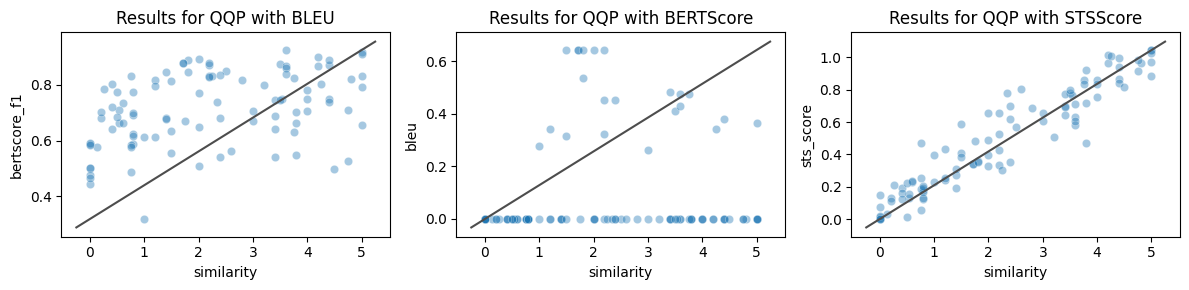

Mean


,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score
label,,,,,
0,0.528632,0.535658,0.531457,0.249297,0.602901
1,0.670192,0.660491,0.665141,0.369275,0.848778


Standard deviation


,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score
label,,,,,
0,0.201773,0.153933,0.155460,0.184903,0.188781
1,0.163284,0.146743,0.141222,0.232385,0.130675


In [75]:
data = load_dataset("stsb_multi_mt", name="en", split="test")
data = data.rename_column("similarity_score", "label")
scores_qqp = pd.DataFrame(fetch_scores(scorer, bleu, data, 'sentence1', 'sentence2'))

def draw_diagonal(ax):
    ax.plot(ax.get_xlim(), ax.get_ylim(), c=".3")

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
sns.scatterplot(x="label", y="bertscore_f1", data=scores_qqp, alpha=0.4, ax=axes[0])
sns.scatterplot(x="label", y="bleu", data=scores_qqp, alpha=0.4, ax=axes[1])
sns.scatterplot(x="label", y="sts_score", data=scores_qqp, alpha=0.4, ax=axes[2])
draw_diagonal(axes[0])
draw_diagonal(axes[1])
draw_diagonal(axes[2])
axes[0].set_title("Results for QQP with BLEU")
axes[0].set_xlabel("similarity")
axes[1].set_title("Results for QQP with BERTScore")
axes[1].set_xlabel("similarity")
axes[2].set_title("Results for QQP with STSScore")
axes[2].set_xlabel("similarity")
fig.tight_layout()
plt.savefig('plots/stsb.pdf', bbox_inches='tight')
plt.show()
print('Mean')
display(scores_mrpc.groupby('label').mean())
print('Standard deviation')
display(scores_mrpc.groupby('label').std())
scores_mrpc.to_csv('scores/stsb.csv')

## MRPC

Found cached dataset glue (/home/sherbold/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 3/3 [00:00<00:00, 1360.17it/s]


1725


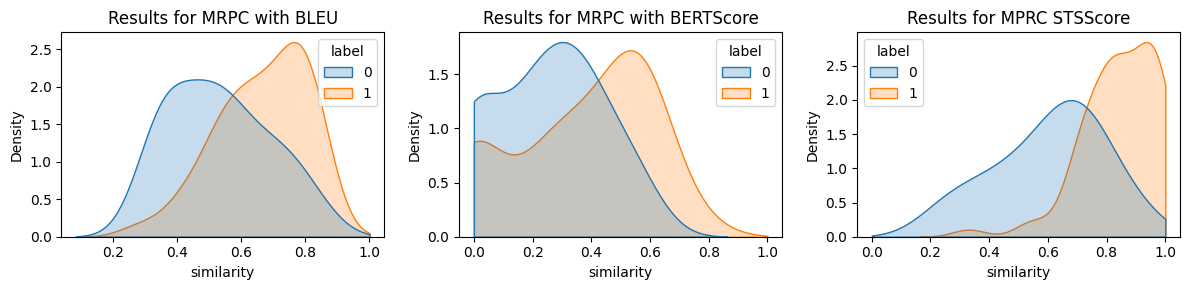

Mean


,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score
label,,,,,
0,0.528632,0.535658,0.531457,0.249297,0.602901
1,0.670192,0.660491,0.665141,0.369275,0.848778


Standard deviation


,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score
label,,,,,
0,0.201773,0.153933,0.155460,0.184903,0.188781
1,0.163284,0.146743,0.141222,0.232385,0.130675


In [31]:
data = load_dataset('glue', 'mrpc')['test']
scores_mrpc = pd.DataFrame(fetch_scores(scorer, bleu, data, 'sentence1', 'sentence2'))
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
sns.kdeplot(scores_mrpc, x="bleu", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[1])
sns.kdeplot(scores_mrpc, x="bertscore_f1", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[0])
sns.kdeplot(scores_mrpc, x="sts_score", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[2])
axes[0].set_title("Results for MRPC with BLEU")
axes[0].set_xlabel("similarity")
axes[1].set_title("Results for MRPC with BERTScore")
axes[1].set_xlabel("similarity")
axes[2].set_title("Results for MPRC STSScore")
axes[2].set_xlabel("similarity")
sns.move_legend(axes[2], "upper left")
fig.tight_layout()
plt.savefig('plots/mrpc.pdf', bbox_inches='tight')
plt.show()
print('Mean')
display(scores_mrpc.groupby('label').mean())
print('Standard deviation')
display(scores_mrpc.groupby('label').std())
scores_mrpc.to_csv('scores/mrpc.csv')

## QQP

Found cached dataset glue (/home/sherbold/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 3/3 [00:00<00:00, 1339.89it/s]


3668


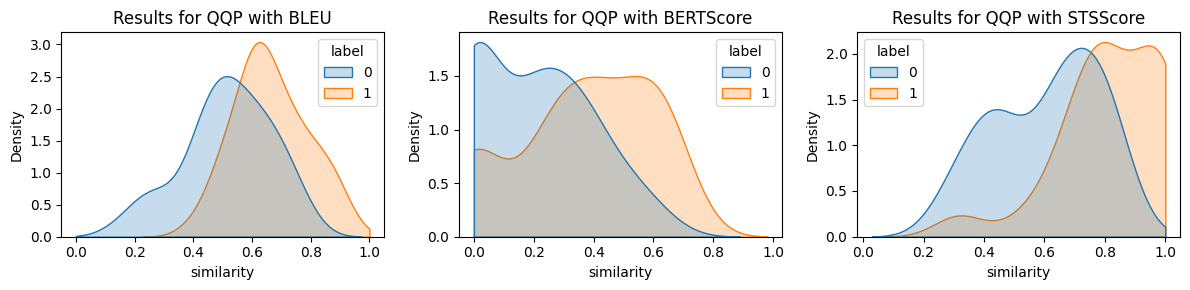

Mean


,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score
label,,,,,
0,0.528632,0.535658,0.531457,0.249297,0.602901
1,0.670192,0.660491,0.665141,0.369275,0.848778


Standard deviation


,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score
label,,,,,
0,0.201773,0.153933,0.155460,0.184903,0.188781
1,0.163284,0.146743,0.141222,0.232385,0.130675


In [32]:
data = load_dataset('glue', 'mrpc')['train']
scores_qqp = pd.DataFrame(fetch_scores(scorer, bleu, data, 'sentence1', 'sentence2'))
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
sns.kdeplot(scores_qqp, x="bleu", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[1])
sns.kdeplot(scores_qqp, x="bertscore_f1", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[0])
sns.kdeplot(scores_qqp, x="sts_score", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[2])
axes[0].set_title("Results for QQP with BLEU")
axes[0].set_xlabel("similarity")
axes[1].set_title("Results for QQP with BERTScore")
axes[1].set_xlabel("similarity")
axes[2].set_title("Results for QQP with STSScore")
axes[2].set_xlabel("similarity")
sns.move_legend(axes[2], "upper left")
fig.tight_layout()
plt.savefig('plots/qqp.pdf', bbox_inches='tight')
plt.show()
print('Mean')
display(scores_mrpc.groupby('label').mean())
print('Standard deviation')
display(scores_mrpc.groupby('label').std())
scores_mrpc.to_csv('scores/qqp.csv')